In [1]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

In [2]:
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [3]:
df = pd.read_csv('https://api.covid19india.org/csv/latest/state_wise_daily.csv')
df

,Date,Status,TT,AN,AP,AR,AS,BR,CH,CT,...,PB,RJ,SK,TN,TG,TR,UP,UT,WB,UN
0,14-Mar-20,Confirmed,81,0,1,0,0,0,0,0,...,1,3,0,1,1,0,12,0,0,0
1,14-Mar-20,Recovered,9,0,0,0,0,0,0,0,...,0,1,0,0,0,0,4,0,0,0
2,14-Mar-20,Deceased,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15-Mar-20,Confirmed,27,0,0,0,0,0,0,0,...,0,1,0,0,2,0,1,0,0,0
4,15-Mar-20,Recovered,4,0,0,0,0,0,0,0,...,0,2,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,30-Jun-20,Recovered,12565,0,279,1,314,170,15,100,...,103,299,1,2325,1712,0,578,120,411,0
326,30-Jun-20,Deceased,506,0,7,0,1,5,0,0,...,6,8,0,60,7,0,25,2,15,0
327,01-Jul-20,Confirmed,18341,3,657,0,140,216,6,82,...,100,304,0,3882,1018,8,564,66,611,-89
328,01-Jul-20,Recovered,11684,0,477,0,184,267,3,53,...,122,354,0,2852,788,0,545,86,398,0


In [4]:
confirmed_df = df[df.Status == "Confirmed"]
confirmed_df = confirmed_df.reset_index(drop = True)
confirmed_df

,Date,Status,TT,AN,AP,AR,AS,BR,CH,CT,...,PB,RJ,SK,TN,TG,TR,UP,UT,WB,UN
0,14-Mar-20,Confirmed,81,0,1,0,0,0,0,0,...,1,3,0,1,1,0,12,0,0,0
1,15-Mar-20,Confirmed,27,0,0,0,0,0,0,0,...,0,1,0,0,2,0,1,0,0,0
2,16-Mar-20,Confirmed,15,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,17-Mar-20,Confirmed,11,0,0,0,0,0,0,0,...,0,0,0,0,1,0,2,0,1,0
4,18-Mar-20,Confirmed,37,0,0,0,0,0,0,0,...,1,3,0,1,8,0,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,27-Jun-20,Confirmed,20142,0,796,3,246,302,3,65,...,99,284,0,3713,1087,9,606,66,521,-100
106,28-Jun-20,Confirmed,19610,11,813,5,327,244,3,84,...,160,327,1,3940,983,12,598,32,572,-184
107,29-Jun-20,Confirmed,18339,7,793,5,302,394,3,101,...,202,389,0,3949,975,34,681,8,624,-554
108,30-Jun-20,Confirmed,18256,7,704,4,613,370,6,63,...,150,348,0,3943,945,8,664,50,652,-281


In [5]:
recovered_df = df[df.Status == "Recovered"]
deceased_df = df[df.Status == "Deceased"]

In [6]:
confirmed_df = confirmed_df.drop("Status", axis = 1)


In [7]:
daily_conf_cases = confirmed_df.iloc[0:,1]
daily_conf_cases.index = pd.to_datetime(confirmed_df['Date'])
daily_conf_cases.head()


Date
2020-03-14    81
2020-03-15    27
2020-03-16    15
2020-03-17    11
2020-03-18    37
Name: TT, dtype: int64

(110,)

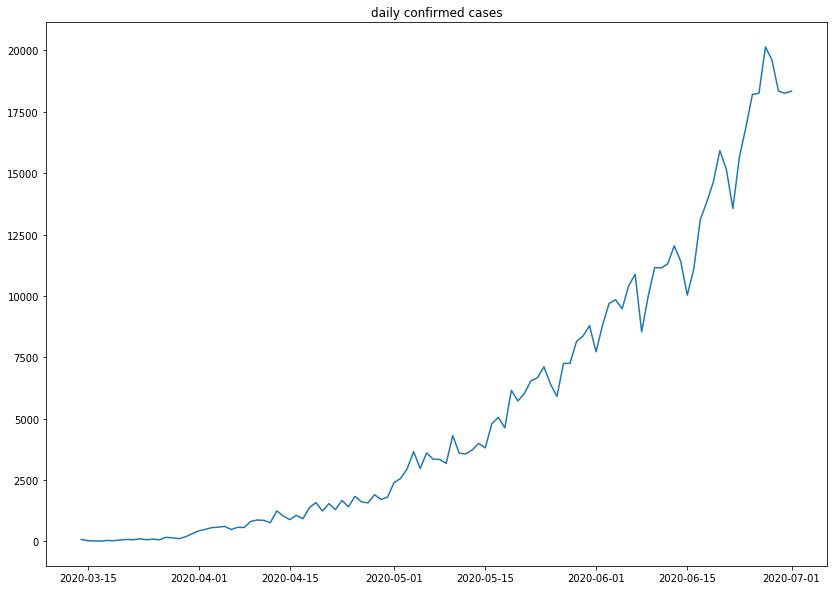

In [8]:
plt.plot(daily_conf_cases)
plt.title("daily confirmed cases");
daily_conf_cases.shape

In [9]:
test_data_size = 40

train_data = daily_conf_cases[:-test_data_size]
test_data = daily_conf_cases[-test_data_size:]
print(train_data.shape)
print(test_data.shape)

(70,)
(40,)


In [10]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_data[:, np.newaxis])
train_data = scaler.transform(train_data[:, np.newaxis])
test_data = scaler.transform(test_data[:, np.newaxis])
print(train_data[:5])
print(test_data[:5])

[[0.01072797]
 [0.00245211]
 [0.00061303]
 [0.        ]
 [0.00398467]]
[[1.0194636 ]
 [1.08812261]
 [0.98130268]
 [0.90360153]
 [1.10881226]]


In [11]:
def create_seq(data, seq_len):
    x = []
    y = []
    for i in range(len(data)-seq_len-1):
        x1 = data[i:(i+seq_len)]
        y1 = data[i+seq_len]
        x.append(x1)
        y.append(y1)
    return np.array(x), np.array(y)

In [12]:
seq_len = 5
xtrain, ytrain = create_seq(train_data, seq_len)
xtest, ytest = create_seq(test_data, seq_len)
xtrain = torch.from_numpy(xtrain).float()
ytrain = torch.from_numpy(ytrain).float()
xtest = torch.from_numpy(xtest).float()
ytest = torch.from_numpy(ytest).float()

In [13]:
print(xtrain.shape)
print(xtrain[:2])

torch.Size([64, 5, 1])
tensor([[[0.0107],
         [0.0025],
         [0.0006],
         [0.0000],
         [0.0040]],

        [[0.0025],
         [0.0006],
         [0.0000],
         [0.0040],
         [0.0025]]])


In [14]:
print(ytrain.shape)
print(ytrain[:2])

torch.Size([64, 1])
tensor([[0.0025],
        [0.0072]])


In [15]:
train_data[:10]

array([[0.01072797],
       [0.00245211],
       [0.00061303],
       [0.        ],
       [0.00398467],
       [0.00245211],
       [0.00720307],
       [0.0102682 ],
       [0.00858238],
       [0.01394636]])

In [52]:
class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [53]:
def train_model(
  model, 
  train_data, 
  train_labels, 
  test_data=None, 
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 60

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(xtrain)

    loss = loss_fn(y_pred.float(), ytrain)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(xtest)
        test_loss = loss_fn(y_test_pred.float(), ytest)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
  
  return model.eval(), train_hist, test_hist

In [54]:
model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_len, 
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model, 
  xtrain, 
  ytrain, 
  xtest, 
  ytest
)

Epoch 0 train loss: 9.408554077148438 test loss: 138.77703857421875
Epoch 10 train loss: 4.131710052490234 test loss: 90.02400207519531
Epoch 20 train loss: 3.816401481628418 test loss: 61.96381378173828
Epoch 30 train loss: 2.330899238586426 test loss: 433.1860046386719
Epoch 40 train loss: 0.6687045097351074 test loss: 782.85009765625
Epoch 50 train loss: 0.5896377563476562 test loss: 816.4271240234375


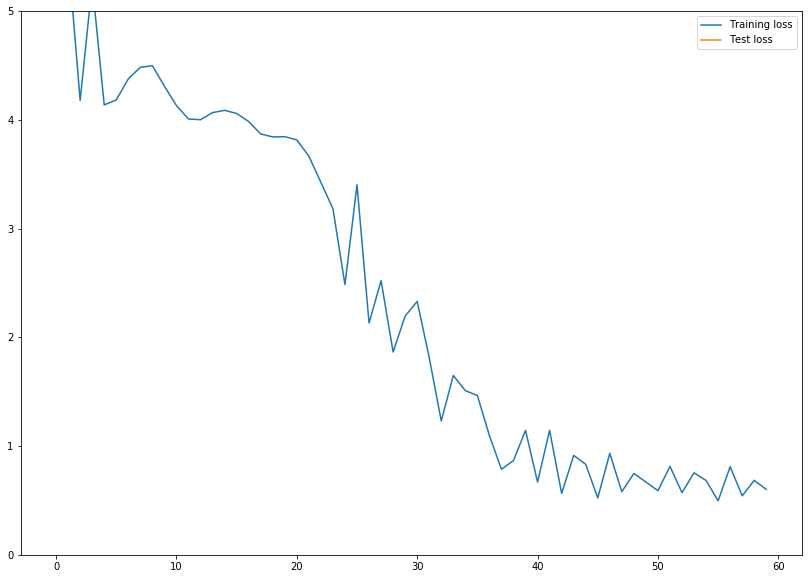

In [55]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 5))
plt.legend();

In [56]:
with torch.no_grad():
  test_seq = xtest[:1]
  preds = []
  for _ in range(len(xtest)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_len, 1).float()

In [57]:
true_cases = scaler.inverse_transform(
    np.expand_dims(ytest.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

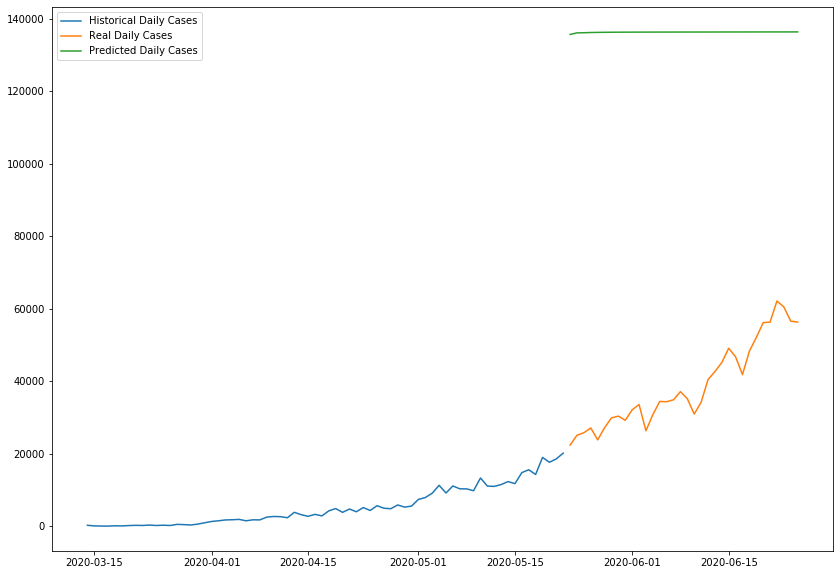

In [58]:
plt.plot(
  daily_conf_cases.index[:len(train_data)], 
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)

plt.plot(
  daily_conf_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  true_cases,
  label='Real Daily Cases'
)

plt.plot(
  daily_conf_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  predicted_cases, 
  label='Predicted Daily Cases'
)

plt.legend();

In [59]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(daily_conf_cases, axis=1))

all_data = scaler.transform(np.expand_dims(daily_conf_cases, axis=1))

all_data.shape

(110, 1)

In [60]:
X_all, y_all = create_seq(all_data, seq_len)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_len, 
  n_layers=2
)
model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 10.098687171936035
Epoch 10 train loss: 4.568647861480713
Epoch 20 train loss: 3.9974019527435303
Epoch 30 train loss: 3.0660006999969482
Epoch 40 train loss: 2.3950560092926025
Epoch 50 train loss: 0.6892182230949402


In [47]:
DAYS_TO_PREDICT = 12
with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_len, 1).float()

In [48]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [49]:
daily_conf_cases.index[-1]

Timestamp('2020-07-01 00:00:00')

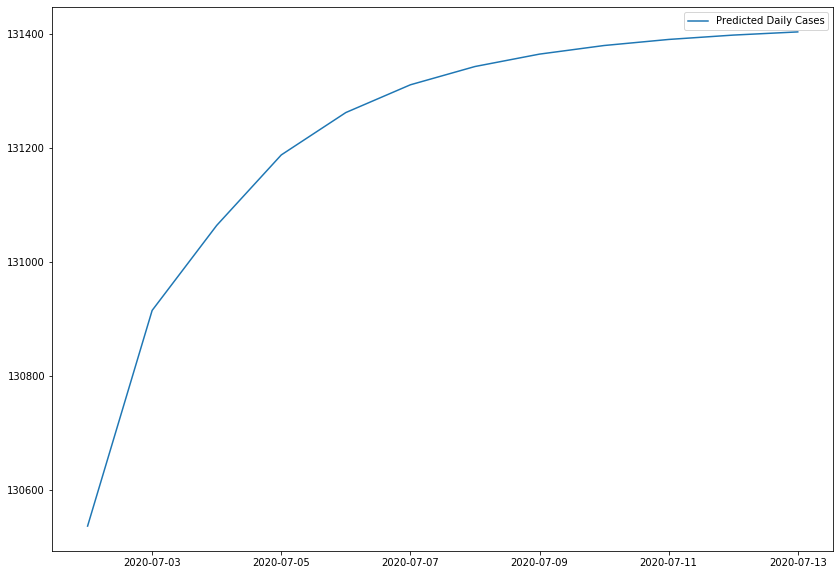

In [50]:
predicted_index = pd.date_range(
  start=daily_conf_cases.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

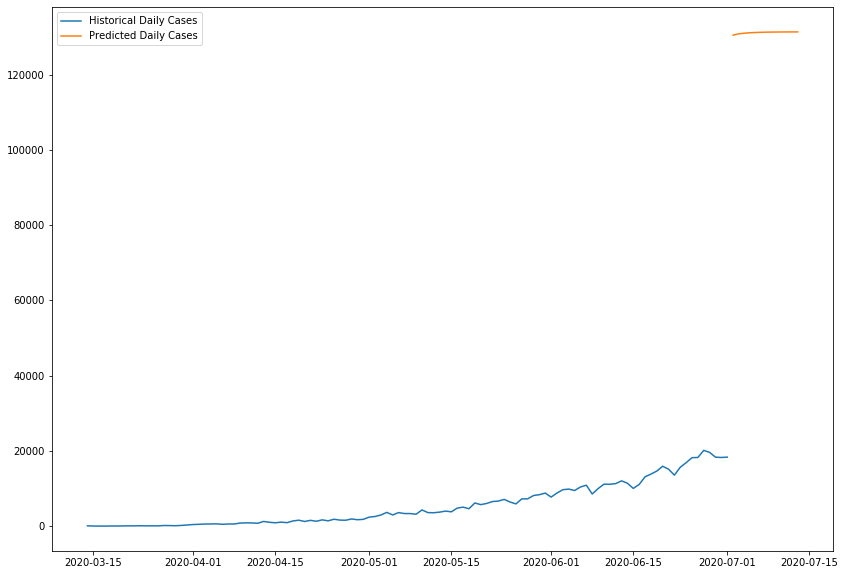

In [51]:
plt.plot(daily_conf_cases, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();